# SEEK + UNSW COMP6713 -Group Project 2025 Term 1

In [1]:
import torch
import os
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq, BartTokenizer, BartForConditionalGeneration, logging, XLMRobertaForQuestionAnswering,XLMRobertaTokenizerFast, XLMRobertaConfig
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import re
from evaluate import load
from sentence_transformers import SentenceTransformer, util
from thefuzz import fuzz
import numpy as np
import accelerate
from torch import nn

warnings.filterwarnings("ignore")
logging.set_verbosity_error()

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


## Work Arrangement

In [2]:
label_map = {"Remote": 0, "OnSite": 1, "Hybrid": 2}

fields = {
    "Job title": "TITLE",
    "Abstract": "ABSTRACT",
    "Employer": "EMPLOYER",
    "Location": "LOCATION",
    "Highlights": "HIGHLIGHTS",
    "Contents": "CONTENTS",
}

def parse_arrange_text(text):
    result = {}
    current_field = None

    for line in text.splitlines():
        line = line.strip()

        if not line:
            continue

        m = re.match(r"^([A-Za-z ]+): (.*)$", line)

        if m and m.group(1) in ["Job title", "Abstract", "Employer", "Location", "Highlights", "Contents"]:
            current_field = m.group(1)
            result[current_field] = m.group(2).strip()
        elif current_field:
            result[current_field] += " " + line

    result_list = []
    for key, value in result.items():
        if key in fields:
            result_list.append(f"[{fields[key]}] {value} [/{fields[key]}]")

    return " ".join(result_list)

In [3]:
df = pd.read_csv('dataset/work_arrangements_development_set.csv')
df["input_list"] = df["job_ad"].apply(lambda x: parse_arrange_text(x))
df["label_idx"] =df["y_true"].map(label_map)

#### XLM RoBERTa Large

Add special tokens

In [4]:
MODEL_NAME = "xlm-roberta-large"
tokenizer = XLMRobertaTokenizerFast.from_pretrained(MODEL_NAME)

tokenizer.add_special_tokens({
    "additional_special_tokens":  [
        "[TITLE]", "[/TITLE]",
        "[ABSTRACT]", "[/ABSTRACT]",
        "[EMPLOYER]", "[/EMPLOYER]",
        "[LOCATION]", "[/LOCATION]",
        "[HIGHLIGHTS]", "[/HIGHLIGHTS]",
        "[CONTENTS]", "[/CONTENTS]",
        "[NATION]", "[/NATION]",
        "[ADDITION]", "[/ADDITION]",
        "[CLASS]", "[/CLASS]",
        "[SUBCLASS]", "[/SUBCLASS]"
    ],
})

mdl_arr = XLMRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3).to(device)
mdl_arr.resize_token_embeddings(len(tokenizer))
mdl_arr.to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250022, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, ou

#### Process Data

use sliding window to process long text

In [5]:
class SlidingWindowDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.cls_id = tokenizer.cls_token_id
        self.sep_id = tokenizer.sep_token_id
        self.pad_id = tokenizer.pad_token_id

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            add_special_tokens=False
        )
        tokens = encoding["input_ids"]

        max_body = self.max_len - 2
        if len(tokens) > max_body:
            start = random.randint(0, len(tokens) - max_body)
            tokens = tokens[start : start + max_body]

        input_ids = [self.cls_id] + tokens + [self.sep_id]
        attention_mask = [1] * len(input_ids)

        pad_len = self.max_len - len(input_ids)
        input_ids += [self.pad_id] * pad_len
        attention_mask += [0] * pad_len

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [6]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label_idx"]
)

train_dataset = SlidingWindowDataset(
    train_df["input_list"].tolist(),
    train_df["label_idx"].tolist(),
    tokenizer,
    max_len=512
)
val_dataset = SlidingWindowDataset(
    val_df["input_list"].tolist(),
    val_df["label_idx"].tolist(),
    tokenizer,
    max_len=512
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

#### Train Model

In [7]:
EPOCHS = 20

total_steps = len(train_loader) * EPOCHS
optimizer = AdamW(mdl_arr.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)
train_losses : list[float] = []
val_losses : list[float] = []
val_acc : list[float] = []

for epoch in range(EPOCHS):
    mdl_arr.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{EPOCHS}"):
        input_ids = batch["input_ids"].to(device)
        assert input_ids.size(1) <= 512, f"Found sequence of length {input_ids.size(1)}"

        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = mdl_arr(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Average training loss: {avg_train_loss:.4f}")
    train_losses.append(avg_train_loss)

    mdl_arr.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels_batch   = batch["labels"].to(device)

            outputs = mdl_arr(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels_batch
            )
            val_loss += outputs.loss.item()
            preds = outputs.logits.argmax(dim=-1)
            correct += (preds == labels_batch).sum().item()
            total += labels_batch.size(0)

    print(f"Validation loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / total:.4f}")
    val_losses.append(val_loss / len(val_loader))
    val_acc.append(correct / total)

    save_dir = f"model/mdl_arr_epoch{epoch+1}"
    mdl_arr.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)

Training Epoch 1/20: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]


Average training loss: 1.0984
Validation loss: 1.0528, Accuracy: 0.4500


Training Epoch 2/20: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]


Average training loss: 1.0770
Validation loss: 1.0490, Accuracy: 0.4500


Training Epoch 3/20: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.52it/s]


Average training loss: 1.0848
Validation loss: 1.0514, Accuracy: 0.4500


Training Epoch 4/20: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.40it/s]


Average training loss: 1.0830
Validation loss: 1.0465, Accuracy: 0.4500


Training Epoch 5/20: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.22it/s]


Average training loss: 1.0600
Validation loss: 1.0297, Accuracy: 0.4500


Training Epoch 6/20: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.47it/s]


Average training loss: 1.0476
Validation loss: 0.9829, Accuracy: 0.4500


Training Epoch 7/20: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.48it/s]


Average training loss: 0.8934
Validation loss: 0.9937, Accuracy: 0.5500


Training Epoch 8/20: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.48it/s]


Average training loss: 0.8698
Validation loss: 0.8623, Accuracy: 0.5000


Training Epoch 9/20: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]


Average training loss: 0.6599
Validation loss: 0.7505, Accuracy: 0.8000


Training Epoch 10/20: 100%|████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s]


Average training loss: 0.4583
Validation loss: 1.1461, Accuracy: 0.6500


Training Epoch 11/20: 100%|████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]


Average training loss: 0.3461
Validation loss: 0.9175, Accuracy: 0.6500


Training Epoch 12/20: 100%|████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s]


Average training loss: 0.2885
Validation loss: 0.9600, Accuracy: 0.5500


Training Epoch 13/20: 100%|████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]


Average training loss: 0.2135
Validation loss: 0.7558, Accuracy: 0.6500


Training Epoch 14/20: 100%|████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s]


Average training loss: 0.1548
Validation loss: 1.0190, Accuracy: 0.5500


Training Epoch 15/20: 100%|████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.48it/s]


Average training loss: 0.0863
Validation loss: 1.0164, Accuracy: 0.6500


Training Epoch 16/20: 100%|████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]


Average training loss: 0.0579
Validation loss: 0.8792, Accuracy: 0.8000


Training Epoch 17/20: 100%|████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s]


Average training loss: 0.0621
Validation loss: 1.1734, Accuracy: 0.6500


Training Epoch 18/20: 100%|████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]


Average training loss: 0.0536
Validation loss: 1.0394, Accuracy: 0.6500


Training Epoch 19/20: 100%|████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s]


Average training loss: 0.0522
Validation loss: 1.1111, Accuracy: 0.7000


Training Epoch 20/20: 100%|████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s]


Average training loss: 0.0512
Validation loss: 1.1251, Accuracy: 0.7000


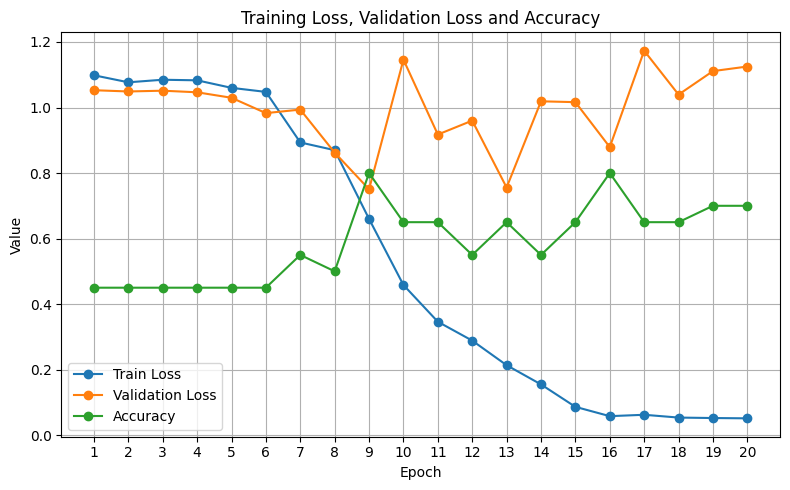

In [8]:
epochs = list(range(1, EPOCHS + 1))
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.plot(epochs, val_acc, label='Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss, Validation Loss and Accuracy')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Test Model

If the input is too long, use average pooling

In [3]:
def sliding_window_predict(
        text: str,
        model: XLMRobertaForSequenceClassification,
        tokenizer: XLMRobertaTokenizerFast,
        device: torch.device,
        max_len: int = 512,
        stride: int = 256,
) -> int:
    model.eval()
    enc = tokenizer(
        text,
        truncation=True,
        max_length=max_len,
        stride=stride,
        return_overflowing_tokens=True,
        padding="max_length",
        return_tensors="pt",
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    all_logits = []
    with torch.no_grad():
        for i in range(input_ids.size(0)):
            out = model(
                input_ids=input_ids[i : i + 1],
                attention_mask=attention_mask[i : i + 1],
            )
            all_logits.append(out.logits.squeeze(0))  # (num_labels,)

    avg_logits = torch.stack(all_logits, dim=0).mean(dim=0)
    return int(avg_logits.argmax().cpu())

In [4]:
df = pd.read_csv('dataset/work_arrangements_test_set.csv')
df["input_list"] = df["job_ad"].apply(lambda x: parse_arrange_text(x))
df["label_idx"] =df["y_true"].map(label_map)

Based on the validation results, we selected epochs 9 and 13 for testing because they achieved the lowest loss. Interestingly, although epoch 13 had a lower accuracy on the validation set, it outperformed epoch 9 on the much larger test set. This discrepancy is likely due to the very small size of the validation set, which makes its estimates less stable.

In [14]:
mdl_arr = XLMRobertaForSequenceClassification.from_pretrained("model/mdl_arr_epoch13", local_files_only=True)
tokenizer = XLMRobertaTokenizerFast.from_pretrained("model/mdl_arr_epoch13", local_files_only=True)
mdl_arr.to(device)

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250022, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, ou

In [15]:
df = pd.read_csv("dataset/test_arrangement.csv")

pred = []
for text in tqdm(df["input_list"]):
    pred.append(sliding_window_predict(text, mdl_arr, tokenizer, device))


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:05<00:00, 18.88it/s]


In [16]:
acc  = accuracy_score(df["label_idx"], pred)
prec = precision_score(df["label_idx"], pred, average="macro")
rec  = recall_score(df["label_idx"], pred, average="macro")
f1   = f1_score(df["label_idx"], pred, average="macro")

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

Accuracy : 0.6970
Precision: 0.7380
Recall   : 0.7023
F1-score : 0.7031


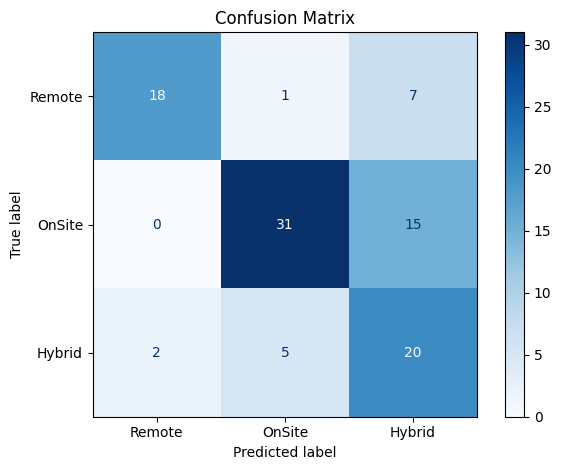

In [20]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=df["label_idx"],
    y_pred=pred,
    display_labels=label_map.keys(),
    cmap="Blues",
    normalize=None
)

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

#### Confusion Matrix Analysis

Below is the 3×3 confusion matrix for the Work Arrangement task (True × Predicted):

| True \ Predicted | Remote | OnSite | Hybrid |
|------------------|:------:|:------:|:------:|
| **Remote**       |   18   |    1   |    7   |
| **OnSite**       |    0   |   31   |   15   |
| **Hybrid**       |    2   |    5   |   20   |

##### Per‑Class Precision & Recall

- **Remote**
  - **Precision** = 18 / (18 + 0 + 2) = **90.0%**
  - **Recall**    = 18 / (18 + 1 + 7) = **69.2%**
  - **Insight**: Most true Remote jobs are correctly flagged, and few non‑Remote are misclassified as Remote. However, 7 Remote postings are mistaken for Hybrid.

- **OnSite**
  - **Precision** = 31 / (1 + 31 + 5) = **83.8%**
  - **Recall**    = 31 / (0 + 31 + 15) = **67.4%**
  - **Insight**: Pure OnSite roles are often recognized, but 15 of them leak into Hybrid—indicating confusion between “strictly on‑site” and “mixed” setups.

- **Hybrid**
  - **Precision** = 20 / (7 + 15 + 20) = **47.6%**
  - **Recall**    = 20 / (2 + 5 + 20) = **74.1%**
  - **Insight**: While most true Hybrid roles are captured, nearly half of the “Hybrid” predictions are actually Remote or OnSite, showing that the model over‑assigns the Hybrid label as a default “gray area.”

##### Major Error Patterns

1. **OnSite → Hybrid** (15 cases)
2. **Remote → Hybrid** (7 cases)
3. **Hybrid → OnSite** (5 cases)

In other words, **Hybrid** acts as a “catch‑all” when the model is uncertain, leading to many false positives.

## Seniority

#### Process Data

Removing HTML structure to reduce token count would impact the number of tokens but offers little practical benefit.

In [10]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text(" ", strip=True)

In [11]:
def parse_salary_row(row):
    parts = []

    if pd.notna(row["job_title"]):
        parts.append(f"[TITLE] {row['job_title'].strip()} [/TITLE]")

    if pd.notna(row["job_summary"]):
        parts.append(f"[ABSTRACT] {row['job_summary'].strip()} [/ABSTRACT]")

    if pd.notna(row["temp"]):
        parts.append(f"[CONTENTS] {row['temp'].strip()} [/CONTENTS]")

    if pd.notna(row["classification_name"]):
        parts.append(f"[CLASS] {row['classification_name'].strip()} [/CLASS]")

    if pd.notna(row["subclassification_name"]):
        parts.append(f"[SUBCLASS] {row['subclassification_name'].strip()} [/SUBCLASS]")

    return " ".join(parts)

In [4]:
df = pd.read_csv('dataset/seniority_labelled_development_set.csv')
df["temp"] = df["job_ad_details"].apply(lambda x: remove_html_tags(x))
df["input_list"] = df.apply(parse_salary_row, axis=1)

#### Bart Large

In [5]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
added = tokenizer.add_special_tokens({
    "additional_special_tokens": [
        "[TITLE]", "[/TITLE]",
        "[ABSTRACT]", "[/ABSTRACT]",
        "[EMPLOYER]", "[/EMPLOYER]",
        "[LOCATION]", "[/LOCATION]",
        "[HIGHLIGHTS]", "[/HIGHLIGHTS]",
        "[CONTENTS]", "[/CONTENTS]",
        "[NATION]", "[/NATION]",
        "[ADDITION]", "[/ADDITION]",
        "[CLASS]", "[/CLASS]",
        "[SUBCLASS]", "[/SUBCLASS]"
    ]
})

model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")
model.resize_token_embeddings(len(tokenizer))

BartScaledWordEmbedding(50285, 1024, padding_idx=1)

In [12]:
class SlidingWindowDatasetMT5(Dataset):
    def __init__(self, texts, labels, tokenizer, max_input_len=512, max_target_len=12):
        self.texts    = texts
        self.labels   = [str(l) for l in labels]
        self.tokenizer= tokenizer
        self.max_input_len  = max_input_len
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_input_len,
            return_attention_mask=True,
        )
        input_ids      = enc["input_ids"]
        attention_mask = enc["attention_mask"]

        tgt = self.tokenizer(
            label,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_target_len,
        )
        labels = tgt["input_ids"]

        return {
            "input_ids":      torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels":         torch.tensor(labels, dtype=torch.long),
        }

#### Evaluation

Because our task requires open-ended label generation—where tokens like “large” and “big” carry the same meaning but never match character for character—we use the pre-trained sentence embedding model paraphrase-multilingual-MiniLM-L12-v2 to judge semantic equivalence.  By computing the cosine similarity between these embeddings, we capture true semantic closeness rather than mere string overlap.  As a result, lexically different but conceptually identical outputs are correctly scored as accurate, making our evaluation both more robust and more reflective of real language variation.

In [13]:
sbert  = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
alpha  = 0.5

In [14]:
def compute_metrics(eval_preds):
    pred_ids, label_ids = eval_preds

    decoded_preds = tokenizer.batch_decode(
        pred_ids, skip_special_tokens=True
    )
    cleaned_labels = [
        [(l if l >= 0 else tokenizer.pad_token_id) for l in seq]
        for seq in label_ids
    ]
    decoded_labels = tokenizer.batch_decode(
        cleaned_labels, skip_special_tokens=True
    )

    pairs = [
        (p.strip(), r.strip())
        for p, r in zip(decoded_preds, decoded_labels)
        if p.strip() and r.strip()
    ]
    if not pairs:
        return {
            "mean_semantic_similarity": 0.0,
            "mean_string_similarity":   0.0,
            "mean_hybrid_similarity":   0.0,
            "exact_match_rate":         0.0,
        }

    preds, refs = zip(*pairs)

    emb_preds = sbert.encode(preds, convert_to_tensor=True)
    emb_refs  = sbert.encode(refs,  convert_to_tensor=True)
    sim_matrix = util.cos_sim(emb_preds, emb_refs)
    sim_sem    = torch.diagonal(sim_matrix).cpu().numpy()

    sim_str = np.array([fuzz.ratio(p, r) / 100.0
                        for p, r in zip(preds, refs)])

    sim_hybrid = alpha * sim_sem + (1 - alpha) * sim_str

    exact_matches = np.array([1.0 if p == r else 0.0
                              for p, r in zip(preds, refs)])

    return {
        "mean_semantic_similarity": float(np.mean(sim_sem)),
        "mean_string_similarity":   float(np.mean(sim_str)),
        "mean_hybrid_similarity":   float(np.mean(sim_hybrid)),
        "exact_match_rate":         float(np.mean(exact_matches)),
    }

#### Train Model

In [9]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
)

train_dataset = SlidingWindowDatasetMT5(
    train_df["input_list"].tolist(),
    train_df["y_true"].tolist(),
    tokenizer,
    max_input_len=1024,
    max_target_len=12
)

val_dataset = SlidingWindowDatasetMT5(
    val_df["input_list"].tolist(),
    val_df["y_true"].tolist(),
    tokenizer,
    max_input_len=1024,
    max_target_len=12
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    padding="longest",
    label_pad_token_id=tokenizer.pad_token_id,
)

In [10]:
training_args = Seq2SeqTrainingArguments(
    output_dir="model",
    predict_with_generate=True,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=125,
    save_steps=125,
    load_best_model_at_end=True,
    metric_for_best_model="mean_hybrid_similarity",
    greater_is_better=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=4,
    logging_strategy="steps",
    logging_steps=125,
    fp16=True,
    disable_tqdm=False,
    learning_rate=3e-5,
    warmup_ratio=0.1,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss,Validation Loss,Mean Semantic Similarity,Mean String Similarity,Mean Hybrid Similarity,Exact Match Rate
125,2.905200,1.866767,0.663092,0.607332,0.635212,0.426497
250,1.227800,1.808222,0.712646,0.666334,0.689490,0.504537
375,0.976100,1.558843,0.730976,0.691706,0.711341,0.542650
500,0.738000,2.120743,0.513301,0.430967,0.472134,0.202555
625,0.595500,0.756124,0.764870,0.724083,0.744477,0.586207
750,0.537400,1.341034,0.697960,0.640799,0.669379,0.484574
875,0.590000,0.779192,0.770981,0.726189,0.748585,0.588022
1000,0.432700,0.775121,0.768085,0.727078,0.747582,0.589837
1125,0.426600,1.028754,0.763187,0.720399,0.741793,0.593466
1250,0.426800,0.810413,0.757169,0.717786,0.737477,0.584392


TrainOutput(global_step=2204, training_loss=0.6455184102274761, metrics={'train_runtime': 863.3327, 'train_samples_per_second': 10.198, 'train_steps_per_second': 2.553, 'total_flos': 1.1671803174100992e+16, 'train_loss': 0.6455184102274761, 'epoch': 4.0})

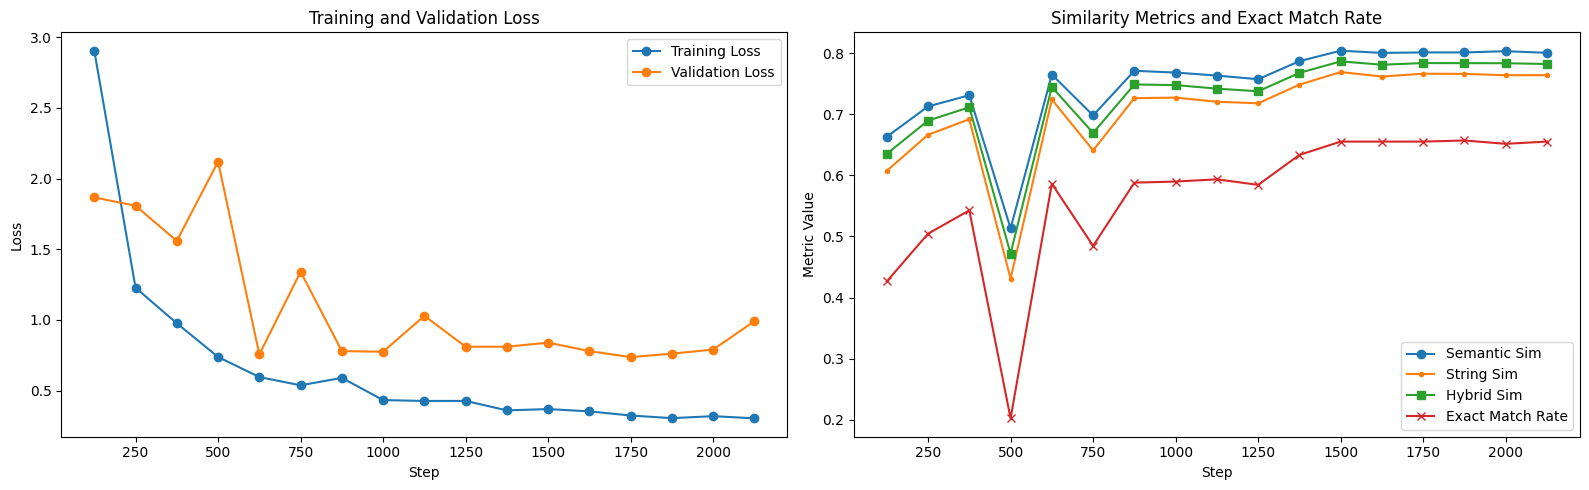

In [9]:
df = pd.read_csv("result.csv")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(df['Step'], df['Training Loss'], label='Training Loss', marker='o')
axes[0].plot(df['Step'], df['Validation Loss'], label='Validation Loss', marker='o')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

axes[1].plot(df['Step'], df['Mean Semantic Similarity'], label='Semantic Sim', marker='o')
axes[1].plot(df['Step'], df['Mean String Similarity'],   label='String Sim', marker='.')
axes[1].plot(df['Step'], df['Mean Hybrid Similarity'],   label='Hybrid Sim', marker='s')
axes[1].plot(df['Step'], df['Exact Match Rate'],         label='Exact Match Rate', marker='x')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Metric Value')
axes[1].set_title('Similarity Metrics and Exact Match Rate')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Test Model

In [16]:
checkpoint = "model/checkpoint-1500"

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
tokenizer.add_special_tokens({
    "additional_special_tokens":[
        "[TITLE]", "[/TITLE]", "[ABSTRACT]", "[/ABSTRACT]",
        "[EMPLOYER]", "[/EMPLOYER]", "[LOCATION]", "[/LOCATION]",
        "[HIGHLIGHTS]", "[/HIGHLIGHTS]", "[CONTENTS]", "[/CONTENTS]",
        "[NATION]", "[/NATION]", "[ADDITION]", "[/ADDITION]",
        "[CLASS]", "[/CLASS]", "[SUBCLASS]", "[/SUBCLASS]"
    ]
})

model = BartForConditionalGeneration.from_pretrained(checkpoint)
model.resize_token_embeddings(len(tokenizer))

BartScaledWordEmbedding(50285, 1024, padding_idx=1)

In [17]:
df = pd.read_csv('dataset/seniority_labelled_test_set.csv')
df["temp"] = df["job_ad_details"].apply(lambda x: remove_html_tags(x))
df["input_list"] = df.apply(parse_salary_row, axis=1)

In [18]:
ds = SlidingWindowDatasetMT5(
    df["input_list"].tolist(),
    df["y_true"].tolist(),
    tokenizer,
    max_input_len=1024,
    max_target_len=12
)

In [19]:
eval_args = Seq2SeqTrainingArguments(
    output_dir="eval_tmp",
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    logging_strategy="no",
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding="longest",
    label_pad_token_id=tokenizer.pad_token_id,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=eval_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

metrics = trainer.evaluate(eval_dataset=ds)

{'eval_loss': 0.8604002594947815, 'eval_model_preparation_time': 0.0025, 'eval_mean_semantic_similarity': 0.784532368183136, 'eval_mean_string_similarity': 0.7467489114658926, 'eval_mean_hybrid_similarity': 0.7656406061292905, 'eval_exact_match_rate': 0.613933236574746, 'eval_runtime': 55.3722, 'eval_samples_per_second': 12.443, 'eval_steps_per_second': 3.124}


In [20]:
print("== Final Test Metrics ==")
print(f"Mean Semantic Similarity : {metrics['eval_mean_semantic_similarity']:.4f}")
print(f"Mean String Similarity   : {metrics['eval_mean_string_similarity']:.4f}")
print(f"Mean Best Similarity     : {metrics.get('eval_mean_best_similarity', metrics['eval_mean_hybrid_similarity']):.4f}")
print(f"Exact Match Rate         : {metrics['eval_exact_match_rate']:.4f}")

== Final Test Metrics ==
Mean Semantic Similarity : 0.7845
Mean String Similarity   : 0.7467
Mean Best Similarity     : 0.7656
Exact Match Rate         : 0.6139


#### Analysis

- **High Semantic Alignment (0.7845)**
  A mean SBERT cosine of ~0.78 tells us that, on average, the model’s predictions occupy very similar regions of semantic space as the references.  In practice this means most generated labels—even if phrased differently—carry the correct concept.
- **Strong Surface Matching (0.7467)**
  A fuzzy‐ratio string score of ~0.75 shows that beyond pure meaning, the model often reproduces labels with high character‐level overlap.  There’s still a ~25% gap from perfect surface match, indicating occasional synonyms, abbreviations, or formatting differences.
- **Best‐of‐Both Worlds (0.7656)**
  By taking the higher of semantic vs. string similarity per example, we get ~0.77.  This “best similarity” gives the model the benefit of the doubt: if it’s phrased differently but semantically correct, it still earns credit.  It sits naturally between the two individual metrics.
- **Strict Exact Match (0.6139)**
  Only ~61% of predictions are character‐perfect matches.  This gap underscores that while the model “understands” most labels (high semantic score), it still often diverges in phrasing.  Improving normalization (e.g. mapping synonyms back to canonical forms) or extending beam search could raise this.

## Salary

#### Preprocess Text Part 1

First, preprocess these sections by removing any HTML formatting, then merge the multiple parts into a single CSV file.

In [2]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text(" ", strip=True)

In [3]:
def parse_salary_row(row):
    parts = []

    if pd.notna(row["job_title"]):
        parts.append(f" {row['job_title'].strip()} ")

    if pd.notna(row["temp"]):
        parts.append(f" {row['temp'].strip()} ")

    if pd.notna(row["nation_short_desc"]):
        parts.append(f" {row['nation_short_desc'].strip()} ")

    if pd.notna(row["salary_additional_text"]):
        parts.append(f" {row['salary_additional_text'].strip()} ")

    return " ".join(parts).replace("\n", " ").replace("\r", " ").replace("\t", " ").strip()

In [5]:
df = pd.read_csv('dataset/salary_labelled_development_set.csv')
df["temp"] = df["job_ad_details"].apply(lambda x: remove_html_tags(x))
df["input_list"] = df.apply(parse_salary_row, axis=1)

df.to_csv('dataset/dev_salary.csv', columns=["input_list", "y_true"], index=False)

#### Preprocess Text Part 2

##### Min and Max Salary
We used Label Studio to annotate the minimum and maximum salary values for every job ad, producing a JSON file that records each “min” and “max” span’s character positions. For example:

```json
[
    {
      "input_list": "Financial Account … Compensation 17500 Compensation Range ₱15,000 - ₱20,000 PH",
      "y_true": "17500-17500-PHP-MONTHLY",
      "id": 1,
      "label": [
        {
          "start": 1291,
          "end": 1296,
          "text": "17500",
          "labels": ["MIN"]
        }
      ],
      "annotator": 1,
      "annotation_id": 1,
      "created_at": "2025-04-24T09:51:52.308486Z",
      "updated_at": "2025-04-24T09:58:01.055057Z",
      "lead_time": 101.4
    }
]
```

During review, we discovered 30 annotations where the annotated min/max salary did not actually appear in the text; because this is a very small fraction, we excluded those entries.

We also corrected a few cases where the min/max spans had been marked at the wrong positions, re-annotating them based on their true semantic context.

##### Period and Currency
Based on our training analysis, we observed that currency and period follow consistent, predictable patterns. Consequently, we reformulated the generation task as a quantitative classification problem, significantly improving our pre-neural network’s accuracy.

In [2]:
period = { 'MONTHLY': 0, 'HOURLY': 1, 'ANNUAL': 2, 'DAILY': 3, 'WEEKLY': 4, 'OTHER': 5  }
currency = { 'PHP': 0, 'HKD': 1, 'NZD': 2, 'MYR': 3, 'AUD': 4, 'SGD': 5, 'THB': 6, 'IDR': 7, 'USD': 8, 'OTHER': 9 }

df = pd.read_json('dataset/label.json')
mask = df['label'].isna() & (df['y_true'] != '0-0-None-None')
df = df.loc[~mask].reset_index(drop=True)
df['label'] = df['label'].apply(lambda x: x if isinstance(x, list) else [])
df['currency'] = df['y_true'].apply(lambda x: currency.get(x.split('-')[2], 9))
df['period'] = df['y_true'].apply(lambda x: period.get(x.split('-')[3], 5))

In [6]:
class SalaryQAAndClassDataset(Dataset):
    def __init__(self, input_list, currency, period, label, tokenizer, max_len=4096):
        self.input_list = input_list
        self.currency   = currency
        self.period     = period
        self.spans_list = label
        self.tokenizer  = tokenizer
        self.max_length = max_len

    def __len__(self):
        return len(self.input_list)

    def __getitem__(self, idx):
        text   = self.input_list[idx]
        spans  = self.spans_list[idx]
        enc = self.tokenizer(
            text,
            return_tensors="pt",
            return_offsets_mapping=True,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
        )
        input_ids      = enc["input_ids"].squeeze(0)
        attention_mask = enc["attention_mask"].squeeze(0)
        offsets        = enc["offset_mapping"].squeeze(0)

        min_start_pos = min_end_pos = max_start_pos = max_end_pos = 0

        for ent in spans:
            s_char, e_char = ent["start"], ent["end"] - 1
            tok_s = enc.char_to_token(s_char)
            tok_e = enc.char_to_token(e_char)
            if tok_s is None or tok_e is None:
                continue

            if "MIN" in ent["labels"]:
                min_start_pos = tok_s
                min_end_pos   = tok_e
            if "MAX" in ent["labels"]:
                max_start_pos = tok_s
                max_end_pos   = tok_e

        return {
            "input_ids":           input_ids,
            "attention_mask":      attention_mask,
            "min_start_positions": torch.tensor(min_start_pos, dtype=torch.long),
            "min_end_positions":   torch.tensor(min_end_pos,   dtype=torch.long),
            "max_start_positions": torch.tensor(max_start_pos, dtype=torch.long),
            "max_end_positions":   torch.tensor(max_end_pos,   dtype=torch.long),
            "currency_labels":     torch.tensor(self.currency[idx], dtype=torch.long),
            "time_labels":         torch.tensor(self.period[idx],   dtype=torch.long),
        }

#### Model Definition

Salary extraction (span extraction) and attribute classification (currency/period) are fundamentally two different tasks: the former requires precisely locating the numeric spans in the text, while the latter requires determining the class of the entire sentence.

We attach a QA‐style span head to both the “minimum salary” and “maximum salary” tasks to predict their start and end positions, and we add two classification heads—on top of the CLS pooled vector—for “currency type” and “payment period” to perform multi‐class classification.

All of these tasks share the same XLM-RoBERTa encoder, allowing the lower-level token and sentence representations to be “borrowed” across tasks: the global semantics learned by the classification heads help the span heads better distinguish contextual boundaries, and vice versa.

In [4]:
class MultiTaskModel(XLMRobertaForQuestionAnswering):
    def __init__(self, model_name, num_currency, num_time):
        config = XLMRobertaConfig.from_pretrained(model_name)

        super().__init__(config)

        pretrained = XLMRobertaForQuestionAnswering.from_pretrained(model_name)
        self.load_state_dict(pretrained.state_dict(), strict=False)

        self.min_qa_outputs = nn.Linear(config.hidden_size, 2)
        self.max_qa_outputs = nn.Linear(config.hidden_size, 2)

        self.currency_classifier = nn.Linear(config.hidden_size, num_currency)
        self.time_classifier     = nn.Linear(config.hidden_size, num_time)

        self.init_weights()

    def forward(
        self,
        input_ids,
        attention_mask=None,
        min_start_positions=None,
        min_end_positions=None,
        max_start_positions=None,
        max_end_positions=None,
        currency_labels=None,
        time_labels=None,
    ):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True,
        )
        seq_out = outputs.last_hidden_state  # (B, L, H)
        pooled = seq_out[:, 0, :]            # (B, H)

        min_logits = self.min_qa_outputs(seq_out)   # (B, L, 2)
        min_start_logits, min_end_logits = min_logits.split(1, dim=-1)
        min_start_logits = min_start_logits.squeeze(-1)  # (B, L)
        min_end_logits   = min_end_logits.squeeze(-1)    # (B, L)

        max_logits = self.max_qa_outputs(seq_out)   # (B, L, 2)
        max_start_logits, max_end_logits = max_logits.split(1, dim=-1)
        max_start_logits = max_start_logits.squeeze(-1)
        max_end_logits   = max_end_logits.squeeze(-1)

        curr_logits = self.currency_classifier(pooled)  # (B, C)
        time_logits = self.time_classifier(pooled)      # (B, T)

        loss = None
        losses = []
        ce = nn.CrossEntropyLoss()

        if min_start_positions is not None and min_end_positions is not None:
            losses += [
                ce(min_start_logits, min_start_positions.squeeze()),
                ce(min_end_logits,   min_end_positions.squeeze())
            ]

        if max_start_positions is not None and max_end_positions is not None:
            losses += [
                ce(max_start_logits, max_start_positions.squeeze()),
                ce(max_end_logits,   max_end_positions.squeeze())
            ]

        if currency_labels is not None:
            losses.append(ce(curr_logits, currency_labels))
        if time_labels is not None:
            losses.append(ce(time_logits, time_labels))

        if losses:
            loss = sum(losses) / len(losses)

        return {
            "loss":              loss,
            "min_start_logits":  min_start_logits,
            "min_end_logits":    min_end_logits,
            "max_start_logits":  max_start_logits,
            "max_end_logits":    max_end_logits,
            "curr_logits":       curr_logits,
            "time_logits":       time_logits,
        }

#### Train Part 1

We start by exclusively training the span extraction heads for the minimum and maximum salary positions. In our training data, when a job ad lacks a min or max salary, we omit any currency or period labels—using a placeholder like “none” in those cases would skew the classification heads. By isolating and pretraining just the span extraction component first, we ensure the model learns to detect salary boundaries without contaminating the currency and period classifiers.

In [6]:
model_name    = "markussagen/xlm-roberta-longformer-base-4096"
num_currency  = len(currency) - 1
num_time      = len(period) - 1

model = MultiTaskModel(model_name, num_currency, num_time)
tokenizer = XLMRobertaTokenizerFast.from_pretrained(model_name)
model.to(device)

MultiTaskModel(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
    

Since our model’s task is solely to locate spans within the text, a 2,048-token context is more than sufficient—there’s no need to process the entire document.

In [7]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
)

train_dataset = SalaryQAAndClassDataset(
    input_list=train_df["input_list"].tolist(),
    currency=train_df["currency"].tolist(),
    period=train_df["period"].tolist(),
    label=train_df["label"].tolist(),
    tokenizer=tokenizer,
    max_len=2048
)

val_dataset = SalaryQAAndClassDataset(
    input_list=val_df["input_list"].tolist(),
    currency=val_df["currency"].tolist(),
    period=val_df["period"].tolist(),
    label=val_df["label"].tolist(),
    tokenizer=tokenizer,
    max_len=2048
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Freeze the classification heads and exclude their label inputs from the forward pass so that no classification loss is computed.

In [8]:
for param in model.currency_classifier.parameters():
    param.requires_grad = False
for param in model.time_classifier.parameters():
    param.requires_grad = False

We use F1 for the min and max spans because span extraction is a highly imbalanced detection task—positive boundary tokens are rare—so we need a metric that balances precision (avoiding false positives) and recall (finding true spans). Plain accuracy would be dominated by the many non-span tokens and wouldn’t reflect true extraction performance.

In [9]:
EPOCHS = 10
total_steps = len(train_loader) * EPOCHS

optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=2e-5,
    weight_decay=0.01,
)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps,
)

for epoch in range(1, EPOCHS + 1):
    # —— 训练阶段 ——
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}/{EPOCHS}"):
        optimizer.zero_grad()
        out = model(
            input_ids            = batch["input_ids"].to(device),
            attention_mask       = batch["attention_mask"].to(device),
            min_start_positions  = batch["min_start_positions"].to(device),
            min_end_positions    = batch["min_end_positions"].to(device),
            max_start_positions  = batch["max_start_positions"].to(device),
            max_end_positions    = batch["max_end_positions"].to(device),
        )
        loss = out["loss"]
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

    avg_epoch_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch}] Training loss: {avg_epoch_loss:.4f}")

    # —— 验证阶段 ——
    model.eval()
    val_loss = 0.0
    min_tp = min_fp = min_fn = 0
    max_tp = max_fp = max_fn = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validating Epoch {epoch}/{EPOCHS}"):
            out = model(
                input_ids            = batch["input_ids"].to(device),
                attention_mask       = batch["attention_mask"].to(device),
                min_start_positions  = batch["min_start_positions"].to(device),
                min_end_positions    = batch["min_end_positions"].to(device),
                max_start_positions  = batch["max_start_positions"].to(device),
                max_end_positions    = batch["max_end_positions"].to(device),
            )
            val_loss += out["loss"].item()

            # —— MIN span metrics ——
            pred_min_s = out["min_start_logits"].argmax(dim=1)
            pred_min_e = out["min_end_logits"].argmax(dim=1)
            true_min_s = batch["min_start_positions"].to(device).squeeze()
            true_min_e = batch["min_end_positions"].to(device).squeeze()
            for ps, pe, ts, te in zip(pred_min_s, pred_min_e, true_min_s, true_min_e):
                if ps == ts and pe == te:
                    min_tp += 1
                else:
                    min_fp += 1
                    min_fn += 1

            # —— MAX span metrics ——
            pred_max_s = out["max_start_logits"].argmax(dim=1)
            pred_max_e = out["max_end_logits"].argmax(dim=1)
            true_max_s = batch["max_start_positions"].to(device).squeeze()
            true_max_e = batch["max_end_positions"].to(device).squeeze()
            for ps, pe, ts, te in zip(pred_max_s, pred_max_e, true_max_s, true_max_e):
                if ps == ts and pe == te:
                    max_tp += 1
                else:
                    max_fp += 1
                    max_fn += 1

    avg_val_loss = val_loss / len(val_loader)

    # 计算 MIN span F1
    prec_min = min_tp / (min_tp + min_fp + 1e-12)
    rec_min  = min_tp / (min_tp + min_fn + 1e-12)
    f1_min   = 2 * prec_min * rec_min / (prec_min + rec_min + 1e-8)

    # 计算 MAX span F1
    prec_max = max_tp / (max_tp + max_fp + 1e-12)
    rec_max  = max_tp / (max_tp + max_fn + 1e-12)
    f1_max   = 2 * prec_max * rec_max / (prec_max + rec_max + 1e-8)

    print(
        f"[Epoch {epoch}] Val loss: {avg_val_loss:.4f}  "
        f"F1(min): {f1_min:.4f}  F1(max): {f1_max:.4f}"
    )

    # —— 保存模型 ——
    save_dir = f"checkpoints/epoch_{epoch}"
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))
    tokenizer.save_pretrained(save_dir)

Training Epoch 1/10: 100%|███████████████████████████████████████████████████████████| 224/224 [03:17<00:00,  1.13it/s]


[Epoch 1] Training loss: 4.0512


Validating Epoch 1/10: 100%|███████████████████████████████████████████████████████████| 56/56 [00:20<00:00,  2.67it/s]


[Epoch 1] Val loss: 0.8989  F1(min): 0.6540  F1(max): 0.6071


Training Epoch 2/10: 100%|███████████████████████████████████████████████████████████| 224/224 [03:17<00:00,  1.13it/s]


[Epoch 2] Training loss: 0.8199


Validating Epoch 2/10: 100%|███████████████████████████████████████████████████████████| 56/56 [00:21<00:00,  2.66it/s]


[Epoch 2] Val loss: 0.5440  F1(min): 0.6674  F1(max): 0.6607


Training Epoch 3/10: 100%|███████████████████████████████████████████████████████████| 224/224 [03:17<00:00,  1.13it/s]


[Epoch 3] Training loss: 0.5711


Validating Epoch 3/10: 100%|███████████████████████████████████████████████████████████| 56/56 [00:20<00:00,  2.67it/s]


[Epoch 3] Val loss: 0.4935  F1(min): 0.6786  F1(max): 0.6629


Training Epoch 4/10: 100%|███████████████████████████████████████████████████████████| 224/224 [03:17<00:00,  1.13it/s]


[Epoch 4] Training loss: 0.4941


Validating Epoch 4/10: 100%|███████████████████████████████████████████████████████████| 56/56 [00:20<00:00,  2.67it/s]


[Epoch 4] Val loss: 0.4484  F1(min): 0.6763  F1(max): 0.6607


Training Epoch 5/10: 100%|███████████████████████████████████████████████████████████| 224/224 [03:17<00:00,  1.13it/s]


[Epoch 5] Training loss: 0.4427


Validating Epoch 5/10: 100%|███████████████████████████████████████████████████████████| 56/56 [00:20<00:00,  2.67it/s]


[Epoch 5] Val loss: 0.4664  F1(min): 0.6942  F1(max): 0.6696


Training Epoch 6/10: 100%|███████████████████████████████████████████████████████████| 224/224 [03:17<00:00,  1.13it/s]


[Epoch 6] Training loss: 0.4021


Validating Epoch 6/10: 100%|███████████████████████████████████████████████████████████| 56/56 [00:21<00:00,  2.66it/s]


[Epoch 6] Val loss: 0.4766  F1(min): 0.7232  F1(max): 0.6830


Training Epoch 7/10: 100%|███████████████████████████████████████████████████████████| 224/224 [03:17<00:00,  1.13it/s]


[Epoch 7] Training loss: 0.3836


Validating Epoch 7/10: 100%|███████████████████████████████████████████████████████████| 56/56 [00:21<00:00,  2.67it/s]


[Epoch 7] Val loss: 0.4784  F1(min): 0.6987  F1(max): 0.7143


Training Epoch 8/10: 100%|███████████████████████████████████████████████████████████| 224/224 [03:17<00:00,  1.13it/s]


[Epoch 8] Training loss: 0.3647


Validating Epoch 8/10: 100%|███████████████████████████████████████████████████████████| 56/56 [00:20<00:00,  2.67it/s]


[Epoch 8] Val loss: 0.5207  F1(min): 0.7277  F1(max): 0.6897


Training Epoch 9/10: 100%|███████████████████████████████████████████████████████████| 224/224 [03:17<00:00,  1.13it/s]


[Epoch 9] Training loss: 0.3432


Validating Epoch 9/10: 100%|███████████████████████████████████████████████████████████| 56/56 [00:21<00:00,  2.67it/s]


[Epoch 9] Val loss: 0.5373  F1(min): 0.7433  F1(max): 0.7143


Training Epoch 10/10: 100%|██████████████████████████████████████████████████████████| 224/224 [03:17<00:00,  1.13it/s]


[Epoch 10] Training loss: 0.3292


Validating Epoch 10/10: 100%|██████████████████████████████████████████████████████████| 56/56 [00:20<00:00,  2.67it/s]


[Epoch 10] Val loss: 0.5578  F1(min): 0.7366  F1(max): 0.7098


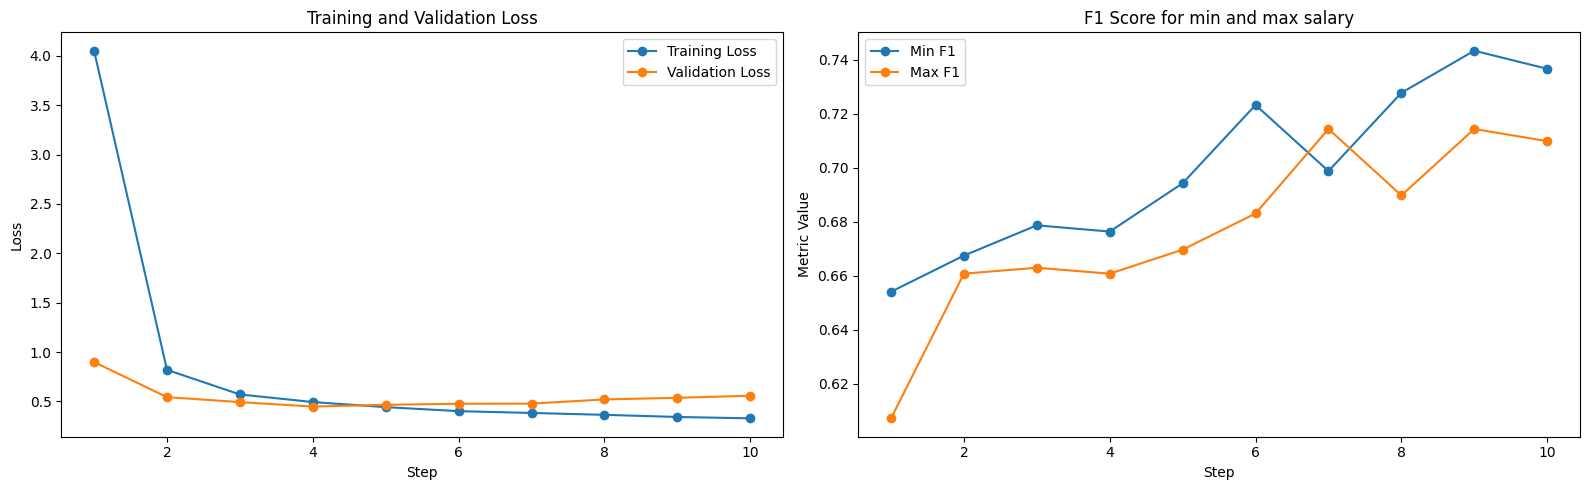

In [18]:
train_loss = [4.0512, 0.8199, 0.5711, 0.4941, 0.4427, 0.4021, 0.3836, 0.3647, 0.3432, 0.3292]
valid_loss = [0.8989, 0.5440, 0.4935, 0.4484, 0.4664, 0.4766, 0.4784, 0.5207, 0.5373, 0.5578]
min = [0.6540, 0.6674, 0.6786, 0.6763, 0.6942, 0.7232, 0.6987, 0.7277, 0.7433, 0.7366]
max = [0.6071, 0.6607, 0.6629, 0.6607, 0.6696, 0.6830, 0.7143, 0.6897, 0.7143, 0.7098]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
step = range(1, len(min) + 1)

axes[0].plot(step, train_loss, label='Training Loss', marker='o')
axes[0].plot(step, valid_loss, label='Validation Loss', marker='o')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

axes[1].plot(step, min, label='Min F1', marker='o')
axes[1].plot(step, max,   label='Max F1', marker='o')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Metric Value')
axes[1].set_title('F1 Score for min and max salary')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Train Part 2

We filter out all “0-0-none-none” entries—keeping only records with actual currency and period labels—to eliminate unnecessary noise. Then, based on our earlier evaluation, we continue training from the epoch-9 checkpoint, where the overall loss is comparable but the min/max salary F1 is highest.

In [5]:
mask = (df['y_true'] == '0-0-None-None')
df = df[~mask]
print(df.shape)

(1288, 11)


In [6]:
model_name   = "markussagen/xlm-roberta-longformer-base-4096"
num_currency = len(currency) - 1
num_time     = len(period)   - 1

model     = MultiTaskModel(model_name, num_currency, num_time)
tokenizer = XLMRobertaTokenizerFast.from_pretrained(model_name)

ckpt_path = "checkpoints/epoch_9/pytorch_model.bin"
state_dict = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

Because the filter dataset is relatively small, we’ve increased the input length to 4,096 tokens so the model can attend to the entire document.

In [7]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
)

train_dataset = SalaryQAAndClassDataset(
    input_list=train_df["input_list"].tolist(),
    currency=train_df["currency"].tolist(),
    period=train_df["period"].tolist(),
    label=train_df["label"].tolist(),
    tokenizer=tokenizer,
    max_len=4096
)

val_dataset = SalaryQAAndClassDataset(
    input_list=val_df["input_list"].tolist(),
    currency=val_df["currency"].tolist(),
    period=val_df["period"].tolist(),
    label=val_df["label"].tolist(),
    tokenizer=tokenizer,
    max_len=4096
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

We freeze the embeddings and the first six Transformer layers—locking in general language features—and leave the top six layers plus all four task heads trainable. This reduces overfitting and speeds up convergence on our small dataset while still allowing the model to adapt high-level representations for salary span extraction and currency/period classification.

In [8]:
for name, param in model.named_parameters():
    if name.startswith("roberta.embeddings."):
        param.requires_grad = False

for layer in model.roberta.encoder.layer[:6]:
    for param in layer.parameters():
        param.requires_grad = False

for layer in model.roberta.encoder.layer[6:]:
    for param in layer.parameters():
        param.requires_grad = True

for head in (
        model.min_qa_outputs, model.max_qa_outputs,
        model.currency_classifier, model.time_classifier
):
    for param in head.parameters():
        param.requires_grad = True

model.to(device)

MultiTaskModel(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
    

By freezing most of the model, we can safely use a higher learning rate to speed up convergence. At the same time, we compute and optimize the classification and extraction heads’ losses in parallel, ensuring both tasks improve together and preventing over‐optimization on any single objective.

In [9]:
EPOCHS = 20
total_steps = len(train_loader) * EPOCHS

optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-4,
    weight_decay=0.01,
)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps,
)

ce = torch.nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    for step, batch in enumerate(tqdm(train_loader, desc=f"Train Classification Epoch {epoch}/{EPOCHS}")):
        optimizer.zero_grad()
        out = model(
            input_ids      = batch["input_ids"].to(device),
            attention_mask = batch["attention_mask"].to(device),
            min_start_positions  = batch["min_start_positions"].to(device),
            min_end_positions    = batch["min_end_positions"].to(device),
            max_start_positions  = batch["max_start_positions"].to(device),
            max_end_positions    = batch["max_end_positions"].to(device),
            currency_labels= batch["currency_labels"].to(device),
            time_labels    = batch["time_labels"].to(device),
        )
        loss = out["loss"]
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    avg_train = train_loss / len(train_loader)
    print(f"Average training loss: {avg_train:.4f}")

    model.eval()
    val_loss = 0.0
    corr_curr = corr_time = total = 0
    min_tp = min_fp = min_fn = 0
    max_tp = max_fp = max_fn = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validate Classification Epoch {epoch}/{EPOCHS}"):
            out = model(
                input_ids      = batch["input_ids"].to(device),
                attention_mask = batch["attention_mask"].to(device),
                min_start_positions  = batch["min_start_positions"].to(device),
                min_end_positions    = batch["min_end_positions"].to(device),
                max_start_positions  = batch["max_start_positions"].to(device),
                max_end_positions    = batch["max_end_positions"].to(device),
                currency_labels= batch["currency_labels"].to(device),
                time_labels    = batch["time_labels"].to(device),
            )
            val_loss += out["loss"].item()

            pred_curr = out["curr_logits"].argmax(dim=1)
            pred_time = out["time_logits"].argmax(dim=1)
            true_curr = batch["currency_labels"].to(device)
            true_time = batch["time_labels"].to(device)

            corr_curr += (pred_curr == true_curr).sum().item()
            corr_time += (pred_time == true_time).sum().item()
            total     += true_curr.size(0)

            pred_min_s = out["min_start_logits"].argmax(dim=1)
            pred_min_e = out["min_end_logits"].argmax(dim=1)
            true_min_s = batch["min_start_positions"].to(device).squeeze()
            true_min_e = batch["min_end_positions"].to(device).squeeze()
            for ps, pe, ts, te in zip(pred_min_s, pred_min_e, true_min_s, true_min_e):
                if ps == ts and pe == te:
                    min_tp += 1
                else:
                    min_fp += 1
                    min_fn += 1

            # —— MAX span metrics ——
            pred_max_s = out["max_start_logits"].argmax(dim=1)
            pred_max_e = out["max_end_logits"].argmax(dim=1)
            true_max_s = batch["max_start_positions"].to(device).squeeze()
            true_max_e = batch["max_end_positions"].to(device).squeeze()
            for ps, pe, ts, te in zip(pred_max_s, pred_max_e, true_max_s, true_max_e):
                if ps == ts and pe == te:
                    max_tp += 1
                else:
                    max_fp += 1
                    max_fn += 1

    avg_val = val_loss / len(val_loader)
    acc_curr = corr_curr / total
    acc_time = corr_time / total

    prec_min = min_tp / (min_tp + min_fp + 1e-12)
    rec_min  = min_tp / (min_tp + min_fn + 1e-12)
    f1_min   = 2 * prec_min * rec_min / (prec_min + rec_min + 1e-8)

    prec_max = max_tp / (max_tp + max_fp + 1e-12)
    rec_max  = max_tp / (max_tp + max_fn + 1e-12)
    f1_max   = 2 * prec_max * rec_max / (prec_max + rec_max + 1e-8)

    print(f"Validation loss: {avg_val:.4f} — Currency Acc: {acc_curr:.4f}, Time Acc: {acc_time:.4f}, F1 (min): {f1_min:4f}, F1 (max): {f1_max:4f}")

    save_dir = f"checkpoints/c_epoch_{epoch}"
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))
    tokenizer.save_pretrained(save_dir)

Train Classification Epoch 1/20: 100%|███████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.8465


Validate Classification Epoch 1/20: 100%|██████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.8052 — Currency Acc: 0.2713, Time Acc: 0.4419, F1 (min): 0.779070, F1 (max): 0.717054


Train Classification Epoch 2/20: 100%|███████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.7945


Validate Classification Epoch 2/20: 100%|██████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.7244 — Currency Acc: 0.5271, Time Acc: 0.6085, F1 (min): 0.697674, F1 (max): 0.736434


Train Classification Epoch 3/20: 100%|███████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.6261


Validate Classification Epoch 3/20: 100%|██████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.6595 — Currency Acc: 0.7248, Time Acc: 0.7171, F1 (min): 0.759690, F1 (max): 0.709302


Train Classification Epoch 4/20: 100%|███████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.4724


Validate Classification Epoch 4/20: 100%|██████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.5004 — Currency Acc: 0.8605, Time Acc: 0.8217, F1 (min): 0.771318, F1 (max): 0.736434


Train Classification Epoch 5/20: 100%|███████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.3746


Validate Classification Epoch 5/20: 100%|██████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.4586 — Currency Acc: 0.8527, Time Acc: 0.8760, F1 (min): 0.740310, F1 (max): 0.744186


Train Classification Epoch 6/20: 100%|███████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.3089


Validate Classification Epoch 6/20: 100%|██████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.4361 — Currency Acc: 0.8876, Time Acc: 0.9225, F1 (min): 0.767442, F1 (max): 0.744186


Train Classification Epoch 7/20: 100%|███████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.2644


Validate Classification Epoch 7/20: 100%|██████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


Validation loss: 0.4659 — Currency Acc: 0.8992, Time Acc: 0.9225, F1 (min): 0.759690, F1 (max): 0.759690


Train Classification Epoch 8/20: 100%|███████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.2124


Validate Classification Epoch 8/20: 100%|██████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.4241 — Currency Acc: 0.9651, Time Acc: 0.9109, F1 (min): 0.786822, F1 (max): 0.748062


Train Classification Epoch 9/20: 100%|███████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.1644


Validate Classification Epoch 9/20: 100%|██████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.4563 — Currency Acc: 0.9690, Time Acc: 0.9574, F1 (min): 0.790698, F1 (max): 0.740310


Train Classification Epoch 10/20: 100%|██████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.1318


Validate Classification Epoch 10/20: 100%|█████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.4456 — Currency Acc: 0.9729, Time Acc: 0.9574, F1 (min): 0.751938, F1 (max): 0.744186


Train Classification Epoch 11/20: 100%|██████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.1155


Validate Classification Epoch 11/20: 100%|█████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.5279 — Currency Acc: 0.9690, Time Acc: 0.9651, F1 (min): 0.732558, F1 (max): 0.748062


Train Classification Epoch 12/20: 100%|██████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.0868


Validate Classification Epoch 12/20: 100%|█████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.5248 — Currency Acc: 0.9729, Time Acc: 0.9651, F1 (min): 0.748062, F1 (max): 0.779070


Train Classification Epoch 13/20: 100%|██████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.0823


Validate Classification Epoch 13/20: 100%|█████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.5399 — Currency Acc: 0.9845, Time Acc: 0.9767, F1 (min): 0.775194, F1 (max): 0.775194


Train Classification Epoch 14/20: 100%|██████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.0836


Validate Classification Epoch 14/20: 100%|█████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.5415 — Currency Acc: 0.9845, Time Acc: 0.9767, F1 (min): 0.802326, F1 (max): 0.767442


Train Classification Epoch 15/20: 100%|██████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.0624


Validate Classification Epoch 15/20: 100%|█████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.5791 — Currency Acc: 0.9884, Time Acc: 0.9767, F1 (min): 0.782946, F1 (max): 0.775194


Train Classification Epoch 16/20: 100%|██████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.0535


Validate Classification Epoch 16/20: 100%|█████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.5876 — Currency Acc: 0.9884, Time Acc: 0.9845, F1 (min): 0.802326, F1 (max): 0.771318


Train Classification Epoch 17/20: 100%|██████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.0498


Validate Classification Epoch 17/20: 100%|█████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.6134 — Currency Acc: 0.9884, Time Acc: 0.9767, F1 (min): 0.794574, F1 (max): 0.782946


Train Classification Epoch 18/20: 100%|██████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.0480


Validate Classification Epoch 18/20: 100%|█████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.5936 — Currency Acc: 0.9884, Time Acc: 0.9806, F1 (min): 0.782946, F1 (max): 0.759690


Train Classification Epoch 19/20: 100%|██████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.0475


Validate Classification Epoch 19/20: 100%|█████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.6062 — Currency Acc: 0.9884, Time Acc: 0.9767, F1 (min): 0.779070, F1 (max): 0.763566


Train Classification Epoch 20/20: 100%|██████████████████████████████████████████████| 129/129 [03:40<00:00,  1.71s/it]


Average training loss: 0.0472


Validate Classification Epoch 20/20: 100%|█████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


Validation loss: 0.6078 — Currency Acc: 0.9884, Time Acc: 0.9767, F1 (min): 0.775194, F1 (max): 0.771318


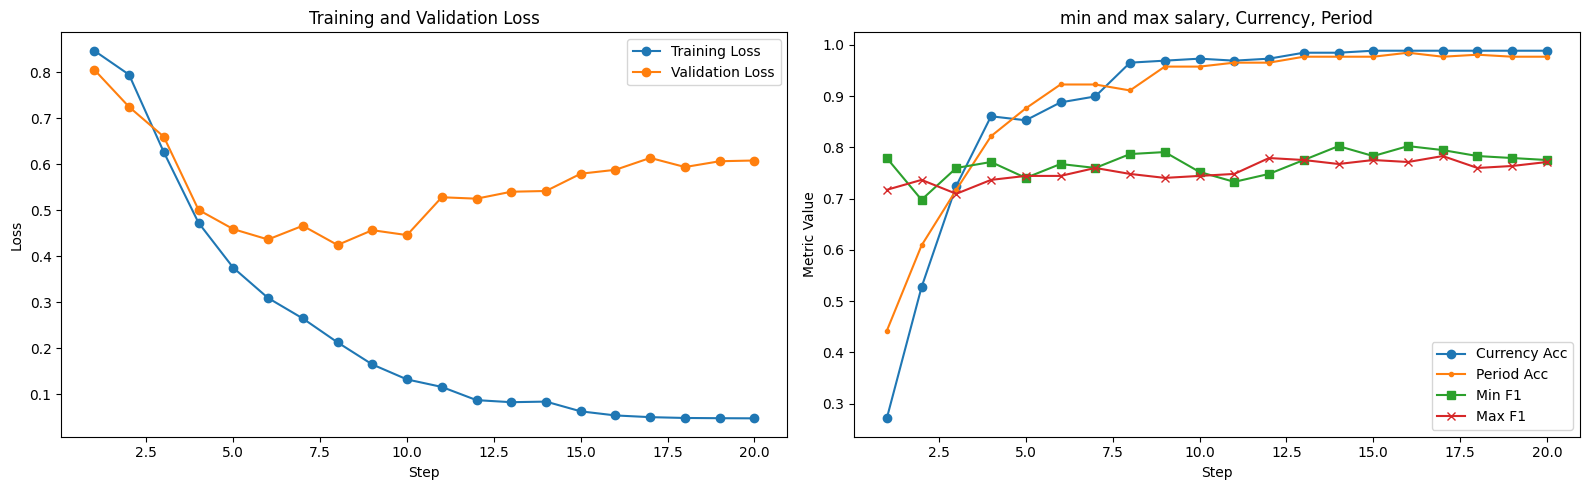

In [20]:
train_loss = [0.8465, 0.7945, 0.6261, 0.4724, 0.3746, 0.3089, 0.2644, 0.2124, 0.1644, 0.1318, 0.1155, 0.0868, 0.0823, 0.0836, 0.0624, 0.0535, 0.0498, 0.0480, 0.0475, 0.0472]
valid_loss = [0.8052, 0.7244, 0.6595, 0.5004, 0.4586, 0.4361, 0.4659, 0.4241, 0.4563, 0.4456, 0.5279, 0.5248, 0.5399, 0.5415, 0.5791, 0.5876, 0.6134, 0.5936, 0.6062, 0.6078]
currency_acc = [0.2713, 0.5271, 0.7248, 0.8605, 0.8527, 0.8876, 0.8992, 0.9651, 0.9690, 0.9729, 0.9690, 0.9729, 0.9845, 0.9845, 0.9884, 0.9884, 0.9884, 0.9884, 0.9884, 0.9884]
period_acc = [0.4419, 0.6085, 0.7171, 0.8217, 0.8760, 0.9225, 0.9225, 0.9109, 0.9574, 0.9574, 0.9651, 0.9651, 0.9767, 0.9767, 0.9767, 0.9845, 0.9767, 0.9806, 0.9767, 0.9767]
min_f1 = [0.779070, 0.697674, 0.759690, 0.771318, 0.740310, 0.767442, 0.759690, 0.786822, 0.790698, 0.751938, 0.732558, 0.748062, 0.775194, 0.802326, 0.782946, 0.802326, 0.794574, 0.782946, 0.779070, 0.775194]
max_f1 = [0.717054, 0.736434, 0.709302, 0.736434, 0.744186, 0.744186, 0.759690, 0.748062, 0.740310, 0.744186, 0.748062, 0.779070, 0.775194, 0.767442, 0.775194, 0.771318, 0.782946, 0.759690, 0.763566, 0.771318]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
step = range(1, len(train_loss) + 1)

axes[0].plot(step, train_loss, label='Training Loss', marker='o')
axes[0].plot(step, valid_loss, label='Validation Loss', marker='o')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

axes[1].plot(step, currency_acc, label='Currency Acc', marker='o')
axes[1].plot(step, period_acc,   label='Period Acc', marker='.')
axes[1].plot(step, min_f1,   label='Min F1', marker='s')
axes[1].plot(step, max_f1,   label='Max F1', marker='x')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Metric Value')
axes[1].set_title('min and max salary, Currency, Period')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Test Model

We use the model’s dedicated min_* and max_* span heads to locate the numeric boundaries in the text. By taking the argmax of each head’s start/end logits, we pinpoint the most likely token indices for the salary spans.

If the predicted end index comes before the start, or the extracted substring contains no digits (after stripping non‐numeric characters), we return 0 to indicate a missing or invalid span. This ensures noisy or out‐of‐context predictions don’t crash downstream code.

When only one of min/max is found, we set the other equal to it. This covers cases like “Salary: 50k” where only one bound is specified, so we still produce a valid range.

We then apply the currency and period classifiers on the pooled [CLS] vector to label the currency type and payment frequency.

In [5]:
def predict_job_salary(
        text: str,
        model,
        tokenizer,
        device,
        currency_list: list[str],
        period_list:   list[str],
        max_len:       int   = 4096
):
    model.eval()
    enc = tokenizer(
        text,
        return_tensors="pt",
        return_offsets_mapping=True,
        truncation=True,
        padding="max_length",
        max_length=max_len,
    )
    input_ids      = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    offsets        = enc["offset_mapping"][0].tolist()

    with torch.no_grad():
        out = model(input_ids=input_ids, attention_mask=attention_mask)

    def extract_span(start_logits, end_logits) -> int:
        s_idx = start_logits[0].argmax().item()
        e_idx = end_logits[0].argmax().item()
        if e_idx < s_idx:
            return 0
        cs, _ = offsets[s_idx]
        _, ce = offsets[e_idx]
        raw = text[cs:ce]
        cleaned = re.sub(r"[^\d\.]", "", raw)
        if not cleaned:
            return 0
        try:
            return int(round(float(cleaned)))
        except:
            return 0

    min_val = extract_span(out["min_start_logits"], out["min_end_logits"])
    max_val = extract_span(out["max_start_logits"], out["max_end_logits"])

    if min_val == 0 and max_val == 0:
        return 0, 0, "None", "None"
    if min_val == 0:
        min_val = max_val
    elif max_val == 0:
        max_val = min_val

    curr_id = out["curr_logits"].argmax(dim=1).item()
    time_id = out["time_logits"].argmax(dim=1).item()
    currency = currency_list[curr_id]
    period   = period_list[time_id]

    return min_val, max_val, currency, period

At epoch 13, the model reached its best combined performance: currency accuracy peaked at ~98.45%, period accuracy at ~97.67%, and the min/max salary F1 scores remained near their highest values. Since the validation loss showed no clear rebound or overfitting by then, epoch 13 offers the optimal trade-off, making it the ideal checkpoint for continued training and deployment.

In [6]:
model_name   = "markussagen/xlm-roberta-longformer-base-4096"

model     = MultiTaskModel(model_name, 9, 5)
tokenizer = XLMRobertaTokenizerFast.from_pretrained(model_name)

ckpt_path = "checkpoints/c_epoch_13/pytorch_model.bin"
state_dict = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [7]:
df = pd.read_csv('dataset/salary_labelled_test_set.csv')
df["temp"] = df["job_ad_details"].apply(lambda x: remove_html_tags(x))
df["input_list"] = df.apply(parse_salary_row, axis=1)

min = df["y_true"].map(lambda x: int(x.split('-')[0])).tolist()
max = df["y_true"].map(lambda x: int(x.split('-')[1])).tolist()
currency = df["y_true"].map(lambda x: x.split('-')[2]).tolist()
period = df["y_true"].map(lambda x: x.split('-')[3]).tolist()

In [8]:
model.to(device)

tar_min, tar_max, tar_currency, tar_period = [], [], [], []
for i in tqdm(df["input_list"].tolist()):
    p_min, p_max, p_cur, p_per = predict_job_salary(
        text=i,
        model=model,
        tokenizer=tokenizer,
        device=device,
        currency_list=['PHP','HKD','NZD','MYR','AUD','SGD','THB','IDR','USD'],
        period_list=['MONTHLY','HOURLY','ANNUAL','DAILY','WEEKLY']
    )
    tar_min.append(p_min)
    tar_max.append(p_max)
    tar_currency.append(p_cur)
    tar_period.append(p_per)

100%|████████████████████████████████████████████████████████████████████████████████| 567/567 [01:04<00:00,  8.79it/s]


Compute the accuracy for each of the four metrics.

In [9]:
acc_min = sum(1 for t, p in zip(min, tar_min) if t == p) / len(min)
acc_max = sum(1 for t, p in zip(max, tar_max) if t == p) / len(max)
acc_currency = sum(1 for t, p in zip(currency, tar_currency) if t == p) / len(currency)
acc_period = sum(1 for t, p in zip(period, tar_period) if t == p) / len(period)

print(f"Accuracy (min values):      {acc_min:.4f}")
print(f"Accuracy (max values):      {acc_max:.4f}")
print(f"Accuracy (currency labels): {acc_currency:.4f}")
print(f"Accuracy (period labels):   {acc_period:.4f}")

Accuracy (min values):      0.9347
Accuracy (max values):      0.9136
Accuracy (currency labels): 0.9612
Accuracy (period labels):   0.9365


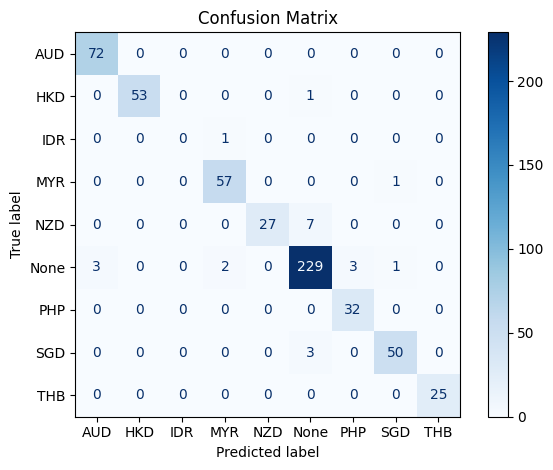

In [11]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=currency,
    y_pred=tar_currency,
    cmap="Blues",
    normalize=None
)

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

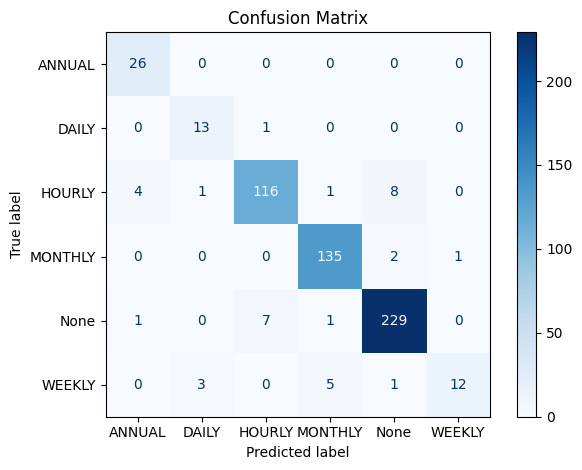

In [13]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=period,
    y_pred=tar_period,
    cmap="Blues",
    normalize=None
)

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Compute the exact‐match accuracy across all four metrics.

In [14]:
exact_matches = sum(
    1
    for tm, pm, tx, px, tc, pc, tp, pp
    in zip(min, tar_min,
           max, tar_max,
           currency, tar_currency,
           period, tar_period)
    if tm == pm and tx == px and tc == pc and tp == pp
)

exact_acc = exact_matches / len(min)
print(f"Exact match rate (min,max,currency,period): {exact_acc:.4f}")

Exact match rate (min,max,currency,period): 0.8695


Since we observed during training annotation that some rounded y_true values didn’t perfectly align with the text, we’ll allow a ±1 tolerance when evaluating matches.

In [15]:
exact_matches = sum(
    1
    for tm, pm, tx, px, tc, pc, tp, pp
    in zip(min, tar_min,
           max, tar_max,
           currency, tar_currency,
           period, tar_period)
    if (tm == pm or tm - 1 == pm or tm + 1 == pm) and (tx == px or tx - 1 == px or tx + 1 == px) and tc == pc and tp == pp
)

exact_acc = exact_matches / len(min)
print(f"Exact match rate (min,max,currency,period): {exact_acc:.4f}")

Exact match rate (min,max,currency,period): 0.8836


#### Analysis

1. Component-Wise Accuracy

| Metric                 | Accuracy |
|------------------------|---------:|
| **Min value extraction**      |   93.47 % |
| **Max value extraction**      |   91.36 % |
| **Currency classification**   |   96.12 % |
| **Period classification**     |   93.65 % |

- **Min vs. Max**: Extracting the minimum salary is slightly more accurate than the maximum (93.5% vs. 91.4%), suggesting the model locates lower‐bound spans more reliably.
- **Currency & Period**: Both classification heads perform very well (>93%), with currency at 96% and period at 93.7%.


2. Confusion Matrix Highlights

Currency
- Almost all major currencies sit on the diagonal (e.g. AUD: 72/72, HKD: 53/54).
- The biggest off-diagonal errors involve `NZD` being confused with `None` and a few stray mislabels in rare classes like `SGD`.

Period
- `ANNUAL` and `MONTHLY` are classified almost perfectly.
- Some confusion occurs between `HOURLY`↔️`DAILY` and `WEEKLY`↔️`MONTHLY`, as well as occasional “None” misclassifications.


3. Exact-Match Rate (all four fields)

| Setting               | Exact-Match |
|-----------------------|------------:|
| **Strict**            |      86.95 % |
| **±1 Tolerance**      |      88.36 % |

- **Strict**: About 87 % of records have _all four_ fields (min, max, currency, period) exactly correct.
- **±1 Tolerance**: Allowing a ±1 difference on the numeric fields raises that to 88.4 %, capturing a few borderline rounding cases.


4. Takeaways & Next Steps

- The model is **very reliable** on currency and period classification, but there is still room to improve the **max value extraction** head.
- Minor confusions in the tails (e.g. `NZD` vs. `None`, `WEEKLY` vs. `MONTHLY`) suggest adding a few more balanced examples or targeted data augmentation.
- With an overall exact‐match above 86 %, this system already meets strong practical requirements;